### User Input

The current simulation is for hypertensive patients without feedback from ANGII·AT1R to renin for 1 day before disease onset (N1) and 10 days after disease onset (N2). The changes in ACE2 from the COVID-19 lung tissue model were applied at disease onset. ueACE2_200.p to ueACE2_2000.p are the extracted mean change of unbound external ACE2 of 15 simulations from the COVID-19 lung tissue model.

In [1]:
pateint_type = 'hypertensive'
#pateint_type = 'normotensive'

#feedback_type = 'with'
feedback_type = 'without'

N1 = 1440   # min, simulation time before disease onset to load premorbid state
N2 = 14400  # min, simulation time after disease onset

Nc = 2      # first loop to reach steady state without ACE2 (N1) and second loop with ACE2 (N2)
number_of_cases = 10

kT = 5e-4       # ANGII induced TGF-beta production rate

### Importing required files and libraries

In [2]:
import glob
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.integrate import odeint
from scipy.integrate import ode
import random, pickle

### Running simulation

In [3]:
for Cases in range(number_of_cases):

    output = []
    result = []
    baseline = 0

    case = Cases + 1

    # hypertensive
    if (pateint_type == 'hypertensive'):
        x1 = 6e5        # Angiotensinogen  fmol/mL
        x2 = 110.0      # ANGI  fmol/mL
        x3 = 156.0      # ANGII  fmol/mL
        x4 = 92.0       # ANG(1-7)  fmol/mL
        x5 = 2.1e4      # ACE2-ANGII  fmol/mL
        x6 = 1.0        # ANGIV  fmol/mL
        x7 = 85.0       # ANGII-AT1R  fmol/mL
        x8 = 27.0       # ANGII-AT2R  fmol/mL

    # normotensive
    if (pateint_type == 'normotensive'):
        x1 = 6e5        # Angiotensinogen  fmol/mL
        x2 = 70         # ANGI  fmol/mL
        x3 = 28         # ANGII  fmol/mL
        x4 = 36         # ANG(1-7)  fmol/mL
        x5 = 2.1e4      # ACE2-ANGII  fmol/mL
        x6 = 1          # ANGIV  fmol/mL
        x7 = 15         # ANGII-AT1R  fmol/mL
        x8 = 5          # ANGII-AT2R  fmol/mL


    # Renin [x0] and MAS-ANG(1-7) [x9] are estimated using linear solving, see calculation after linear solving for details
    x10 = 0.0           # Unconverted ANGII
    x11 = 0.0           # TGF-β  ng/mL
    x12 = 0.0           # Macrophage    (population number)
    x13 = 0.0           # Fibroblast    (population number)
    x14 = 0.0           # Collagen  μg



    # parameters for RAS model
    hA = 600            # min
    hA1 = 0.5           # min
    hA2 = 0.5           # min
    hA17 = 0.5          # min
    hA4 = 0.5           # min
    hAT1 = 12           # min
    hAT2 = 12           # min
    hmas = 12           # min
    hR = 12             # min
    cR = 20             # 1/min
    delta = 0.8         # dimensionless parameter to account for the effect of downstream feedback in RAS network


    # parameters for Immune model
    dM = 0.6 / (24 * 60)
    kF = 0.924 / (24 * 60)
    dF = 0.12 / (24 * 60)
    dTB = 15 / (24 * 60)
    kFC = 2.52e-7           # μg/min

    # TGF-beta
    dT = 1.04e-2
    
    # parameters from Jin and ceresa. Their figures are plotted for microliter. To convert pg to ng and uL to mL, units will be similar.
    kMT = 0.07 / (24 * 60)      # TGF-β secretion from macrophages (ng/cell/day in mL (converted from pg/cell/day))
    kFT = 0.004 / (24 * 60)     # TGF-β secretion from fibroblasts

    fACE2 = np.array(pickle.load(open('ueACE2_'+str(case*200)+'.p', 'rb')))


    ##################################################################################################################
    # Linear Solver to solve following set of equations using steady state initial values of RAS peptides

    # beta0 - math.log(2) / hR * x0 = 0
    # kA - cR * x0 - math.log(2) / hA * x1 = 0
    # cR * x0 - cA * ACE_0 * x2 - cN * x2 - math.log(2) / hA1 * x2 = 0
    # cA * ACE_0 * x2 - cAT1 * x3 - cAT2 * x3 - cAPA * x3 - kace2ang2on * ACE2_0 * x3 - math.log(2) / hA2 * x3 = 0
    # cN * x2 + kace2 * x5 - cmas * x4 - math.log(2) / hA17 * x4 = 0
    # kace2ang2on * ACE2_0 * x3 - kace2 * x5 = 0
    # cAPA * x3 - math.log(2) / hA4 * x6 = 0
    # cAT1 * x3 - math.log(2) / hAT1 * x7 = 0
    # cAT2 * x3 - math.log(2) / hAT2 * x8 = 0
    # cmas * x4 - math.log(2) / hmas * x9 = 0

    # 10 unknown parameters are: x0, beta0, kA, cA, kace2ang2on, kace2, cAPA, cAT1, cAT2, x9
    # model assumptions for additional parameters: cmas = cAT2,  cN = 0


    a = np.array([[-math.log(2) / hR, 1, 0, 0, 0, 0, 0, 0, 0, 0], [-cR, 0, 1, 0, 0, 0, 0, 0, 0, 0],
                  [cR, 0, 0, -x2* fACE2[0], 0, 0, 0, 0, 0, 0], [0, 0, 0, x2* fACE2[0],  -x3 * fACE2[0], 0, -x3, -x3, -x3, 0],
                  [0, 0, 0, 0, 0, x5, 0, 0, -x4, 0], [0, 0, 0, 0, x3 * fACE2[0], -x5, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, x3, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, x3, 0, 0],
                  [0, 0, 0, 0, 0, 0, 0, 0, x3, 0], [0, 0, 0, 0, 0, 0, 0, 0, x4, -math.log(2) / hmas]])
    b = np.array([0,math.log(2)/hA * x1, math.log(2)/hA1 * x2, math.log(2)/hA2* x3 , math.log(2)/hA17 * x4, 0, math.log(2)/hA4 * x6, math.log(2)/hAT1 * x7, math.log(2)/hAT2 * x8,0])

    solution = np.linalg.solve(a, b)

    x0 = solution[0]                # Renin  fmol/mL
    beta0 = solution[1]             # fmol/(mL min)
    kA = solution[2]                # fmol/(mL min)
    cA = solution[3]                # 1/(min (# of ACE receptors)), calibration with virtual lung tissue
    kace2ang2on = solution[4]       # 1/(min (# of ACE2 receptors)), calibration with virtual lung tissue
    kace2 = solution[5]             # 1/min
    cAPA = solution[6]              # 1/min
    cAT1 = solution[7]              # 1/min
    cAT2 = solution[8]              # 1/min
    x9 = solution[9]                # MAS-ANG(1-7)  fmol/mL

    # model assumptions
    cmas = cAT2
    cN = 0

    ###########################################################################################


    for i in range(Nc):
        def diff(x, T, baseline,kT):

            if (feedback_type == 'with'):
                if x[7]>=3:
                    beta = beta0 + (math.pow((x7/x[7]),delta)-1)
                else:
                    beta = beta0 + (math.pow((x7/3), delta) - 1)
            if (feedback_type == 'without'):
                beta = beta0


            fACE2 = np.array(pickle.load(open('ueACE2_'+str(case*200)+'.p', 'rb')))
            tACE2 = np.array(pickle.load(open('ueACE2t.p', 'rb')))


            if baseline ==0:
                xI = fACE2[0]
            if baseline == 1:
                xI = np.interp((T/(24*60)), tACE2, fACE2)



            ##########################################################################################################
            # interpolation and extrapolation from experimental data

            # Collected experimental data from literature for macrophage recruitment
            M_data = [30.48, 61.34, 125.78, 88.99, 81.28, 56.42, 46.70]
            T_beta_data1 = [0.05/1000, 0.1/1000, 0.5/1000, 1/1000, 10/1000, 100/1000, 1000/1000]

            # Collected experimental data from literature for fibroblasts recruitment
            Fg_data = [5.35, 8.41, 8.58, 13.58, 28.83]
            T_beta_data2 = [0, 0.01, 0.1, 1, 10]

            # Considering the difference from interpolated value to baseline value
            MTB = np.interp(x[11], T_beta_data1, M_data) - M_data[0]
            FgTB = np.interp(x[11], T_beta_data2, Fg_data) - Fg_data[0]

            ##########################################################################################################


            # Differential equations
            y = [0.0 for i in range(len(x))]

            # Renin
            y[0] = beta - math.log(2) / hR * x[0]

            # Angiotensinogen
            y[1] = kA - cR * (xI/fACE2[0]) * x[0] - math.log(2) / hA * x[1]

            # ANGI
            y[2] = cR * (xI/fACE2[0]) * x[0] - cA * xI * x[2] - cN * x[2] - math.log(2) / hA1 * x[2]

            # ANGII
            y[3] = cA * xI * x[2] - cAT1 * x[3] - cAT2 * x[3] - cAPA * x[3] - kace2ang2on * xI * x[3] - math.log(2) / hA2 * x[3]

            # ANG(1-7)
            y[4] = cN * x[2] + kace2 * x[5] - cmas * x[4] - math.log(2) / hA17 * x[4]

            # ACE2-ANGII
            y[5] = kace2ang2on * xI * x[3] - kace2 * x[5]

            # ANGIV
            y[6] = cAPA * x[3] - math.log(2) / hA4 * x[6]

            # ANGII-AT1R
            y[7] = cAT1 * x[3] - math.log(2) / hAT1 * x[7]

            # ANGII-AT2R
            y[8] = cAT2 * x[3] - math.log(2) / hAT2 * x[8]

            # MAS-ANG(1-7)
            y[9] = cmas * x[4] - math.log(2) / hmas * x[9]

            # Unconverted ANGII (Note: divide by (kace2ang2on *fACE2[0]* x3) only to get the fraction for plotting)
            y[10] = (kace2ang2on *fACE2[0]* x3 - kace2ang2on * xI * x[3])/(kace2ang2on *fACE2[0]* x3) -x[10] 

            # TGF-β (Note: multiplied by (kace2ang2on *fACE2[0]* x3) to covert the fraction into value)
            y[11] = x[10] * kT *kace2ang2on *fACE2[0]* x3 + kMT * x[12] + kFT * x[13] - dT * x[11]

            # Macrophage
            y[12] = MTB / 90 - dM * x[12]

            # Fibroblast
            y[13] = FgTB / (48 * 60) - dF * x[13]

            # Collagen
            y[14] = kFC * ((0.942 * x[11]) / (0.174 + x[11])) * x[13]

            return y


        if i == 0:
            x = (x0, x1, x2, x3, x4, x5, x6, x7, x8, x9, x10, x11, x12, x13, x14)
            T = np.arange(0.0, N1, 0.1)
            result = np.array(odeint(diff, x, T, args=(0, kT)))
            output.append(result)

        else:
            x = (result[-1, 0], result[-1, 1], result[-1, 2], result[-1, 3], result[-1, 4], result[-1, 5], result[-1, 6], result[-1, 7], result[-1, 8], result[-1, 9], result[-1, 10], result[-1, 11], result[-1, 12], result[-1, 13], result[-1, 14])
            T = np.arange(0.0, N2, 0.1)
            result = np.array(odeint(diff, x, T, args=(1, kT)))
            output.append(result)

    result = np.concatenate((np.array(output[0]), np.array(output[1])))
    T = np.arange(-N1, N2, 0.1)

    #####################################################################################################
    # Saving files for plotting
    pickle.dump(result, open('resultT' + str(Cases) + '.p', 'wb'))

### Extracting data from simulation

In [4]:
tc = np.arange(0, N2, 0.1)      # from disease onset
tc1 = np.arange(-N1, N2, 0.1)   # from preload condition
time_interval_from_ode_solution = 10        # depends on interval in ODE solver
N3 = N1*time_interval_from_ode_solution


resultC1 = [[] for _ in range(number_of_cases)]      # dysregulated ACE2
ueACE2 = [[] for _ in range(number_of_cases)]        # cell surface ACE2 dynamics

for i in range(number_of_cases):
    result = np.array(pickle.load(open('resultT'+str(i)+'.p', 'rb')))
    resultC1[i].append(result)

resultC1 = np.array(resultC1)

for i in range(number_of_cases):
    result = np.array(pickle.load(open('ueACE2_'+str((i+1)*200)+'.p', 'rb')))
    ueACE2[i].append(result)

ueACE2 = np.array(ueACE2)
t1 = np.array(pickle.load(open('ueACE2t.p', 'rb')))


plt.rcParams.update({'font.size': 25})

### Generating plot for unbound external ACE2

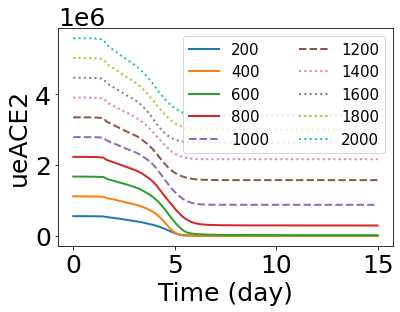

In [5]:
for i in range(number_of_cases):
    if i<4:
        plt.plot(t1, ueACE2[i, 0, :], '-',  linewidth=2)
    if i>=4 and i<6:
        plt.plot(t1, ueACE2[i, 0, :], '--',  linewidth=2)
    if i >= 6:
        plt.plot(t1, ueACE2[i, 0, :], ':', linewidth=2)
        
plt.legend(['200','400','600','800','1000','1200','1400','1600','1800','2000'], ncol = 2, loc='upper right', prop={"size":15})
plt.xlabel('Time (day)')
plt.ylabel('ueACE2')
#plt.savefig("ueACE2.png", dpi = 300, bbox_inches='tight')
plt.show()

### Generating plot for Renin

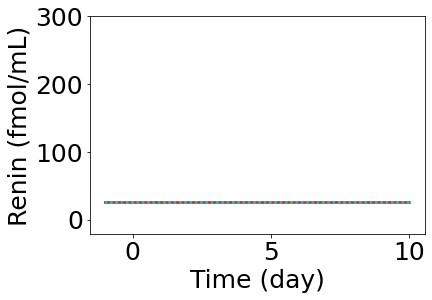

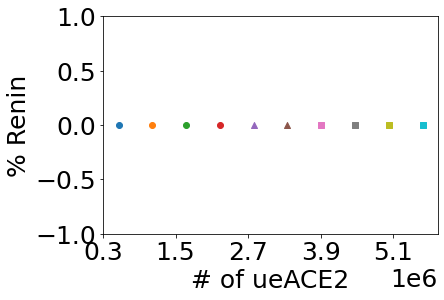

In [6]:
for i in range(number_of_cases):
    if i<4:
        plt.plot(tc1 / (24 * 60), resultC1[i, 0, :, 0], '-',  linewidth=2)
    if i>=4 and i<6:
        plt.plot(tc1 / (24 * 60), resultC1[i, 0, :, 0], '--',  linewidth=2)
    if i >= 6:
        plt.plot(tc1 / (24 * 60), resultC1[i, 0, :, 0], ':', linewidth=2)

plt.ylim([-300*0.07,300])
plt.ticklabel_format(useOffset=False)
#plt.legend(['200','400','600','800','1000','1200','1400','1600','1800','2000'], ncol = 3, prop={"size":15})
plt.xlabel('Time (day)')
plt.ylabel('Renin (fmol/mL)')
#plt.savefig("Renin.png", dpi = 300, bbox_inches='tight')
plt.show()


for i in range(number_of_cases):
    if i<4:
        plt.scatter(ueACE2[i, 0, 0],(resultC1[i, 0, -1, 0] - resultC1[i, 0, N3, 0])*(100/resultC1[i, 0, N3, 0]), marker='o')
    if i>=4 and i<6:
        plt.scatter(ueACE2[i, 0, 0],(resultC1[i, 0, -1, 0] - resultC1[i, 0, N3, 0])*(100/resultC1[i, 0, N3, 0]), marker='^')
    if i >= 6:
        plt.scatter(ueACE2[i, 0, 0],(resultC1[i, 0, -1, 0] - resultC1[i, 0, N3, 0])*(100/resultC1[i, 0, N3, 0]), marker='s')

if feedback_type == 'without':
    plt.ylim([-1,1])
#plt.legend(['200','400','600','800','1000','1200','1400','1600','1800','2000'], ncol = 3, prop={"size":15})
plt.xticks(np.arange(0.3e6, 6.3e6, step=1.2e6))
plt.xlabel('# of ueACE2')
plt.ylabel('% Renin')
#plt.savefig("Renin.png", dpi = 300, bbox_inches='tight')
plt.show()

### Generating plot for Angiotensinogen (AGT)

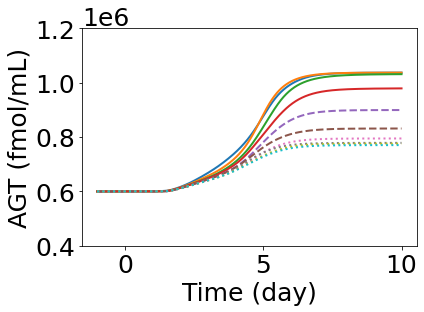

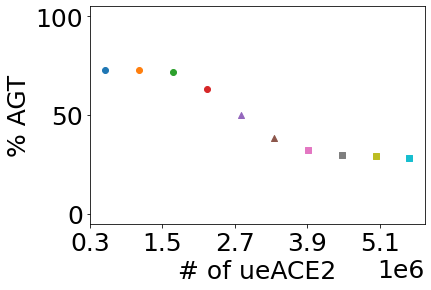

In [7]:
for i in range(number_of_cases):
    if i<4:
        plt.plot(tc1 / (24 * 60), resultC1[i, 0, :, 1], '-',  linewidth=2)
    if i>=4 and i<6:
        plt.plot(tc1 / (24 * 60), resultC1[i, 0, :, 1], '--',  linewidth=2)
    if i >= 6:
        plt.plot(tc1 / (24 * 60), resultC1[i, 0, :, 1], ':', linewidth=2)

plt.ylim([4e5,12e5])
plt.ticklabel_format(useOffset=False)
#plt.legend(['200','400','600','800','1000','1200','1400','1600','1800','2000'], ncol = 3, prop={"size":15})
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.xlabel('Time (day)')
plt.ylabel('AGT (fmol/mL)')
#plt.savefig("AGT.png", dpi = 300, bbox_inches='tight')
plt.show()

for i in range(number_of_cases):
    if i<4:
        plt.scatter(ueACE2[i, 0, 0],(resultC1[i, 0, -1, 1] - resultC1[i, 0, N3, 1])*(100/resultC1[i, 0, N3, 1]), marker='o')
    if i>=4 and i<6:
        plt.scatter(ueACE2[i, 0, 0],(resultC1[i, 0, -1, 1] - resultC1[i, 0, N3, 1])*(100/resultC1[i, 0, N3, 1]), marker='^')
    if i >= 6:
        plt.scatter(ueACE2[i, 0, 0],(resultC1[i, 0, -1, 1] - resultC1[i, 0, N3, 1])*(100/resultC1[i, 0, N3, 1]), marker='s')

plt.ylim([-5,105])
#plt.legend(['200','400','600','800','1000','1200','1400','1600','1800','2000'], ncol = 3, prop={"size":15})
plt.xticks(np.arange(0.3e6, 6.3e6, step=1.2e6))
plt.xlabel('# of ueACE2')
plt.ylabel('% AGT')
#plt.savefig("AGT.png", dpi = 300, bbox_inches='tight')
plt.show()

### Generating overlaying plot for ANGI

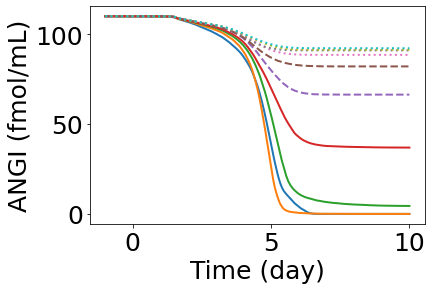

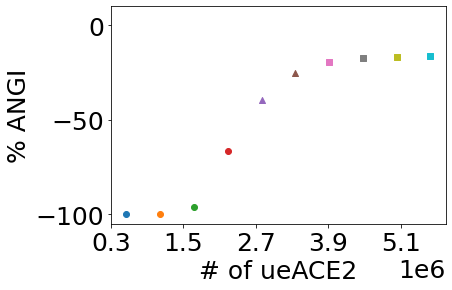

In [8]:
for i in range(number_of_cases):
    if i<4:
        plt.plot(tc1 / (24 * 60), resultC1[i, 0, :, 2], '-',  linewidth=2)
    if i>=4 and i<6:
        plt.plot(tc1 / (24 * 60), resultC1[i, 0, :, 2], '--',  linewidth=2)
    if i >= 6:
        plt.plot(tc1 / (24 * 60), resultC1[i, 0, :, 2], ':', linewidth=2)

#plt.legend(['200','400','600','800','1000','1200','1400','1600','1800','2000'], loc='upper left', prop={"size":15})
plt.xlabel('Time (day)')
plt.ylabel('ANGI (fmol/mL)')
#plt.savefig("ANGI.png", dpi = 300, bbox_inches='tight')
plt.show()

for i in range(number_of_cases):
    if i<4:
        plt.scatter(ueACE2[i, 0, 0],(resultC1[i, 0, -1, 2] - resultC1[i, 0, N3, 2])*(100/resultC1[i, 0, N3, 2]), marker='o')
    if i>=4 and i<6:
        plt.scatter(ueACE2[i, 0, 0],(resultC1[i, 0, -1, 2] - resultC1[i, 0, N3, 2])*(100/resultC1[i, 0, N3, 2]), marker='^')
    if i >= 6:
        plt.scatter(ueACE2[i, 0, 0],(resultC1[i, 0, -1, 2] - resultC1[i, 0, N3, 2])*(100/resultC1[i, 0, N3, 2]), marker='s')
#plt.legend(['200','400','600','800','1000','1200','1400','1600','1800','2000'], loc='upper right', prop={"size":15})
plt.ylim([-105,10])
plt.xticks(np.arange(0.3e6, 6.3e6, step=1.2e6))
plt.xlabel('# of ueACE2')
plt.ylabel('% ANGI')
#plt.savefig("ANGI.png", dpi = 300, bbox_inches='tight')
plt.show()

### Generating overlaying plot for ANGII

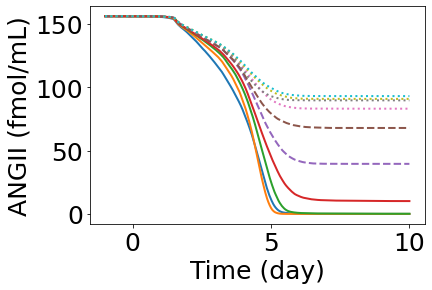

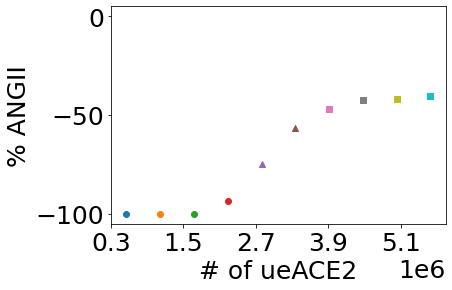

In [9]:
for i in range(number_of_cases):
    if i<4:
        plt.plot(tc1 / (24 * 60), resultC1[i, 0, :, 3], '-',  linewidth=2)
    if i>=4 and i<6:
        plt.plot(tc1 / (24 * 60), resultC1[i, 0, :, 3], '--',  linewidth=2)
    if i >= 6:
        plt.plot(tc1 / (24 * 60), resultC1[i, 0, :, 3], ':', linewidth=2)

#plt.legend(['200','400','600','800','1000','1200','1400','1600','1800','2000'], loc='lower left', prop={"size":15})
plt.xlabel('Time (day)')
plt.ylabel('ANGII (fmol/mL)')
#plt.savefig("ANGII.png", dpi = 300, bbox_inches='tight')
plt.show()

for i in range(number_of_cases):
    if i<4:
        plt.scatter(ueACE2[i, 0, 0],(resultC1[i, 0, -1, 3] - resultC1[i, 0, N3, 3])*(100/resultC1[i, 0, N3, 3]), marker='o')
    if i>=4 and i<6:
        plt.scatter(ueACE2[i, 0, 0],(resultC1[i, 0, -1, 3] - resultC1[i, 0, N3, 3])*(100/resultC1[i, 0, N3, 3]), marker='^')
    if i >= 6:
        plt.scatter(ueACE2[i, 0, 0],(resultC1[i, 0, -1, 3] - resultC1[i, 0, N3, 3])*(100/resultC1[i, 0, N3, 3]), marker='s')
#plt.legend(['200','400','600','800','1000','1200','1400','1600','1800','2000'], loc='lower right', prop={"size":15})
plt.ylim([-105,5])
plt.xticks(np.arange(0.3e6, 6.3e6, step=1.2e6))
plt.xlabel('# of ueACE2')
plt.ylabel('% ANGII')
#plt.savefig("ANGII.png", dpi = 300, bbox_inches='tight')
plt.show()

### Generating overlaying plot for ANG1-7

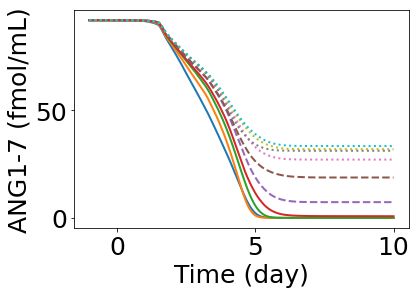

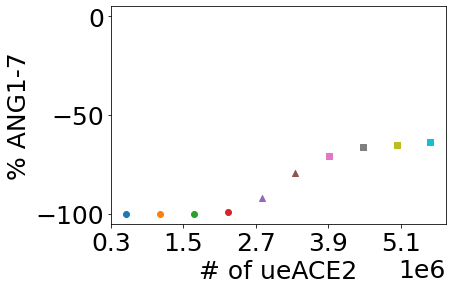

In [10]:
for i in range(number_of_cases):
    if i<4:
        plt.plot(tc1 / (24 * 60), resultC1[i, 0, :, 4], '-',  linewidth=2)
    if i>=4 and i<6:
        plt.plot(tc1 / (24 * 60), resultC1[i, 0, :, 4], '--',  linewidth=2)
    if i >= 6:
        plt.plot(tc1 / (24 * 60), resultC1[i, 0, :, 4], ':', linewidth=2)

#plt.legend(['200','400','600','800','1000','1200','1400','1600','1800','2000'], loc='lower left', prop={"size":15})
plt.xlabel('Time (day)')
plt.ylabel('ANG1-7 (fmol/mL)')
#plt.savefig("ANG1-7.png", dpi = 300, bbox_inches='tight')
plt.show()

for i in range(number_of_cases):
    if i<4:
        plt.scatter(ueACE2[i, 0, 0],(resultC1[i, 0, -1, 4] - resultC1[i, 0, N3, 4])*(100/resultC1[i, 0, N3, 4]), marker='o')
    if i>=4 and i<6:
        plt.scatter(ueACE2[i, 0, 0],(resultC1[i, 0, -1, 4] - resultC1[i, 0, N3, 4])*(100/resultC1[i, 0, N3, 4]), marker='^')
    if i >= 6:
        plt.scatter(ueACE2[i, 0, 0],(resultC1[i, 0, -1, 4] - resultC1[i, 0, N3, 4])*(100/resultC1[i, 0, N3, 4]), marker='s')
#plt.legend(['200','400','600','800','1000','1200','1400','1600','1800','2000'], loc='upper left', prop={"size":15})
plt.ylim([-105,5])
plt.xticks(np.arange(0.3e6, 6.3e6, step=1.2e6))
plt.xlabel('# of ueACE2')
plt.ylabel('% ANG1-7')
#plt.savefig("ANG1-7.png", dpi = 300, bbox_inches='tight')
plt.show()

### Generating overlaying plot for ACE2-ANGII

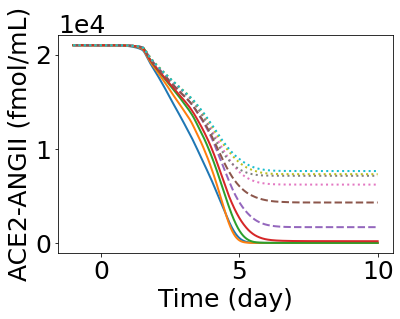

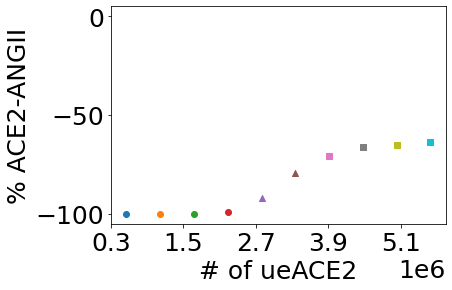

In [11]:
for i in range(number_of_cases):
    if i<4:
        plt.plot(tc1 / (24 * 60), resultC1[i, 0, :, 5], '-',  linewidth=2)
    if i>=4 and i<6:
        plt.plot(tc1 / (24 * 60), resultC1[i, 0, :, 5], '--',  linewidth=2)
    if i >= 6:
        plt.plot(tc1 / (24 * 60), resultC1[i, 0, :, 5], ':', linewidth=2)

plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
#plt.legend(['200','400','600','800','1000','1200','1400','1600','1800','2000'], loc='lower left', prop={"size":15})
plt.xlabel('Time (day)')
plt.ylabel('ACE2-ANGII (fmol/mL)')
#plt.savefig("ACE2-ANGII.png", dpi = 300, bbox_inches='tight')
plt.show()

for i in range(number_of_cases):
    if i<4:
        plt.scatter(ueACE2[i, 0, 0],(resultC1[i, 0, -1, 5] - resultC1[i, 0, N3, 5])*(100/resultC1[i, 0, N3, 5]), marker='o')
    if i>=4 and i<6:
        plt.scatter(ueACE2[i, 0, 0],(resultC1[i, 0, -1, 5] - resultC1[i, 0, N3, 5])*(100/resultC1[i, 0, N3, 5]), marker='^')
    if i >= 6:
        plt.scatter(ueACE2[i, 0, 0],(resultC1[i, 0, -1, 5] - resultC1[i, 0, N3, 5])*(100/resultC1[i, 0, N3, 5]), marker='s')
#plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
#plt.legend(['200','400','600','800','1000','1200','1400','1600','1800','2000'], loc='upper left', prop={"size":15})
plt.ylim([-105,5])
plt.xticks(np.arange(0.3e6, 6.3e6, step=1.2e6))
plt.xlabel('# of ueACE2')
plt.ylabel('% ACE2-ANGII')
#plt.savefig("ACE2-ANGII.png", dpi = 300, bbox_inches='tight')
plt.show()

### Generating overlaying plot for ANGIV

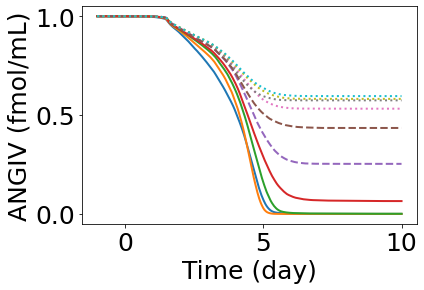

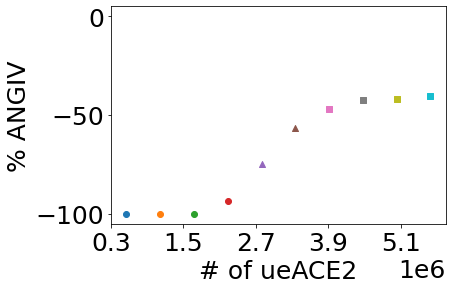

In [12]:
for i in range(number_of_cases):
    if i<4:
        plt.plot(tc1 / (24 * 60), resultC1[i, 0, :, 6], '-',  linewidth=2)
    if i>=4 and i<6:
        plt.plot(tc1 / (24 * 60), resultC1[i, 0, :, 6], '--',  linewidth=2)
    if i >= 6:
        plt.plot(tc1 / (24 * 60), resultC1[i, 0, :, 6], ':', linewidth=2)

#plt.legend(['200','400','600','800','1000','1200','1400','1600','1800','2000'], loc='lower left', prop={"size":15})
plt.xlabel('Time (day)')
plt.ylabel('ANGIV (fmol/mL)')
#plt.savefig("ANGIV.png", dpi = 300, bbox_inches='tight')
plt.show()

for i in range(number_of_cases):
    if i<4:
        plt.scatter(ueACE2[i, 0, 0],(resultC1[i, 0, -1, 6] - resultC1[i, 0, N3, 6])*(100/resultC1[i, 0, N3, 6]), marker='o')
    if i>=4 and i<6:
        plt.scatter(ueACE2[i, 0, 0],(resultC1[i, 0, -1, 6] - resultC1[i, 0, N3, 6])*(100/resultC1[i, 0, N3, 6]), marker='^')
    if i >= 6:
        plt.scatter(ueACE2[i, 0, 0],(resultC1[i, 0, -1, 6] - resultC1[i, 0, N3, 6])*(100/resultC1[i, 0, N3, 6]), marker='s')
#plt.legend(['200','400','600','800','1000','1200','1400','1600','1800','2000'], loc='lower right', prop={"size":15})
plt.ylim([-105,5])
plt.xticks(np.arange(0.3e6, 6.3e6, step=1.2e6))
plt.xlabel('# of ueACE2')
plt.ylabel('% ANGIV')
#plt.savefig("ANGIV.png", dpi = 300, bbox_inches='tight')
plt.show()

### Generating overlaying plot for ANGII-AT1R

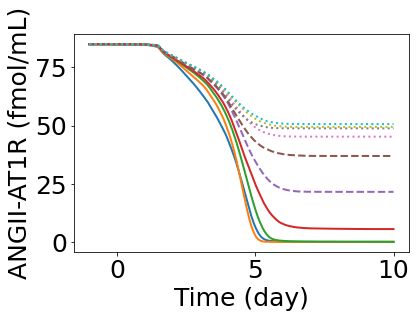

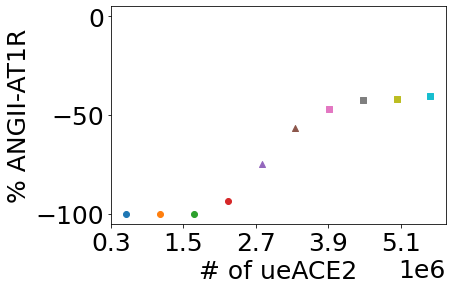

In [13]:
for i in range(number_of_cases):
    if i<4:
        plt.plot(tc1 / (24 * 60), resultC1[i, 0, :, 7], '-',  linewidth=2)
    if i>=4 and i<6:
        plt.plot(tc1 / (24 * 60), resultC1[i, 0, :, 7], '--',  linewidth=2)
    if i >= 6:
        plt.plot(tc1 / (24 * 60), resultC1[i, 0, :, 7], ':', linewidth=2)

#plt.legend(['200','400','600','800','1000','1200','1400','1600','1800','2000'], loc='lower left', prop={"size":15})
plt.xlabel('Time (day)')
plt.ylabel('ANGII-AT1R (fmol/mL)')
#plt.savefig("ANGII-AT1R.png", dpi = 300, bbox_inches='tight')
plt.show()

for i in range(number_of_cases):
    if i<4:
        plt.scatter(ueACE2[i, 0, 0],(resultC1[i, 0, -1, 7] - resultC1[i, 0, N3, 7])*(100/resultC1[i, 0, N3, 7]), marker='o')
    if i>=4 and i<6:
        plt.scatter(ueACE2[i, 0, 0],(resultC1[i, 0, -1, 7] - resultC1[i, 0, N3, 7])*(100/resultC1[i, 0, N3, 7]), marker='^')
    if i >= 6:
        plt.scatter(ueACE2[i, 0, 0],(resultC1[i, 0, -1, 7] - resultC1[i, 0, N3, 7])*(100/resultC1[i, 0, N3, 7]), marker='s')
#plt.legend(['200','400','600','800','1000','1200','1400','1600','1800','2000'], loc='lower right', prop={"size":15})
plt.ylim([-105,5])
plt.xticks(np.arange(0.3e6, 6.3e6, step=1.2e6))
plt.xlabel('# of ueACE2')
plt.ylabel('% ANGII-AT1R')
#plt.savefig("ANGII-AT1R.png", dpi = 300, bbox_inches='tight')
plt.show()

### Generating overlaying plot for ANGII-AT2R

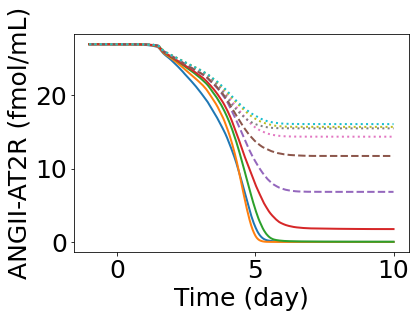

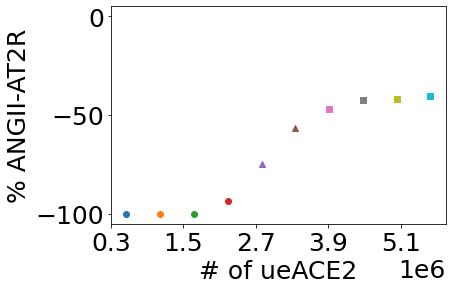

In [14]:
for i in range(number_of_cases):
    if i<4:
        plt.plot(tc1 / (24 * 60), resultC1[i, 0, :, 8], '-',  linewidth=2)
    if i>=4 and i<6:
        plt.plot(tc1 / (24 * 60), resultC1[i, 0, :, 8], '--',  linewidth=2)
    if i >= 6:
        plt.plot(tc1 / (24 * 60), resultC1[i, 0, :, 8], ':', linewidth=2)

#plt.legend(['200','400','600','800','1000','1200','1400','1600','1800','2000'], loc='lower left', prop={"size":15})
plt.xlabel('Time (day)')
plt.ylabel('ANGII-AT2R (fmol/mL)')
#plt.savefig("ANGII-AT2R.png", dpi = 300, bbox_inches='tight')
plt.show()

for i in range(number_of_cases):
    if i<4:
        plt.scatter(ueACE2[i, 0, 0],(resultC1[i, 0, -1, 8] - resultC1[i, 0, N3, 8])*(100/resultC1[i, 0, N3, 8]), marker='o')
    if i>=4 and i<6:
        plt.scatter(ueACE2[i, 0, 0],(resultC1[i, 0, -1, 8] - resultC1[i, 0, N3, 8])*(100/resultC1[i, 0, N3, 8]), marker='^')
    if i >= 6:
        plt.scatter(ueACE2[i, 0, 0],(resultC1[i, 0, -1, 8] - resultC1[i, 0, N3, 8])*(100/resultC1[i, 0, N3, 8]), marker='s')
#plt.legend(['200','400','600','800','1000','1200','1400','1600','1800','2000'], loc='lower right', prop={"size":15})
plt.ylim([-105,5])
plt.xticks(np.arange(0.3e6, 6.3e6, step=1.2e6))
plt.xlabel('# of ueACE2')
plt.ylabel('% ANGII-AT2R')
#plt.savefig("ANGII-AT2R.png", dpi = 300, bbox_inches='tight')
plt.show()

### Generating overlaying plot for MAS-ANG(1-7)

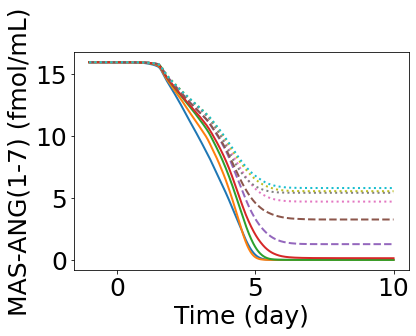

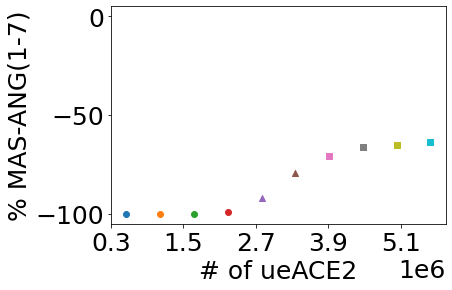

In [15]:
for i in range(number_of_cases):
    if i<4:
        plt.plot(tc1 / (24 * 60), resultC1[i, 0, :, 9], '-',  linewidth=2)
    if i>=4 and i<6:
        plt.plot(tc1 / (24 * 60), resultC1[i, 0, :, 9], '--',  linewidth=2)
    if i >= 6:
        plt.plot(tc1 / (24 * 60), resultC1[i, 0, :, 9], ':', linewidth=2)

#plt.legend(['200','400','600','800','1000','1200','1400','1600','1800','2000'], loc='lower left', prop={"size":15})
plt.xlabel('Time (day)')
plt.ylabel('MAS-ANG(1-7) (fmol/mL)')
#plt.savefig("MAS-ANG(1-7).png", dpi = 300, bbox_inches='tight')
plt.show()

for i in range(number_of_cases):
    if i<4:
        plt.scatter(ueACE2[i, 0, 0],(resultC1[i, 0, -1, 9] - resultC1[i, 0, N3, 9])*(100/resultC1[i, 0, N3, 9]), marker='o')
    if i>=4 and i<6:
        plt.scatter(ueACE2[i, 0, 0],(resultC1[i, 0, -1, 9] - resultC1[i, 0, N3, 9])*(100/resultC1[i, 0, N3, 9]), marker='^')
    if i >= 6:
        plt.scatter(ueACE2[i, 0, 0],(resultC1[i, 0, -1, 9] - resultC1[i, 0, N3, 9])*(100/resultC1[i, 0, N3, 9]), marker='s')
#plt.legend(['200','400','600','800','1000','1200','1400','1600','1800','2000'], loc='upper left', prop={"size":15})
plt.ylim([-105,5])
plt.xticks(np.arange(0.3e6, 6.3e6, step=1.2e6))
plt.xlabel('# of ueACE2')
plt.ylabel('% MAS-ANG(1-7)')
#plt.savefig("MAS-ANG(1-7).png", dpi = 300, bbox_inches='tight')
plt.show()

### Generating overlaying plot for Unconverted ANGII

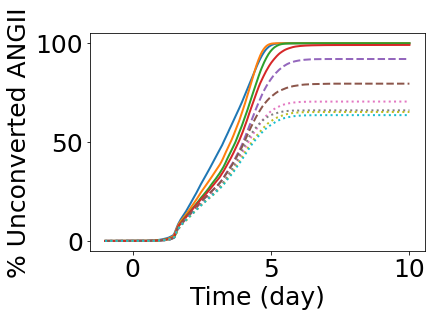

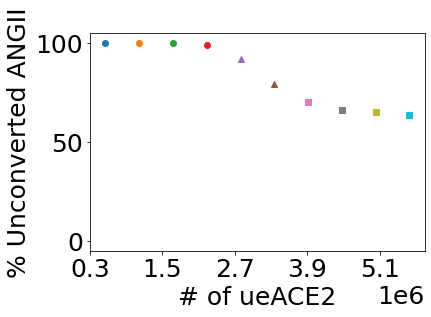

In [16]:
for i in range(number_of_cases):
    if i<4:
        plt.plot(tc1 / (24 * 60), resultC1[i, 0, :, 10]*100, '-',  linewidth=2)
    if i>=4 and i<6:
        plt.plot(tc1 / (24 * 60), resultC1[i, 0, :, 10]*100, '--',  linewidth=2)
    if i >= 6:
        plt.plot(tc1 / (24 * 60), resultC1[i, 0, :, 10]*100, ':', linewidth=2)

plt.ylim([-5,105])
#plt.legend(['200','400','600','800','1000','1200','1400','1600','1800','2000'], loc='upper left', prop={"size":15})
plt.xlabel('Time (day)')
plt.ylabel('% Unconverted ANGII')
#plt.savefig("ANGII_Change.png", dpi = 300, bbox_inches='tight')
plt.show()

for i in range(number_of_cases):
    if i<4:
        plt.scatter(ueACE2[i, 0, 0],(resultC1[i, 0, -1, 10]*100), marker='o')
    if i>=4 and i<6:
        plt.scatter(ueACE2[i, 0, 0],(resultC1[i, 0, -1, 10]*100), marker='^')
    if i >= 6:
        plt.scatter(ueACE2[i, 0, 0],(resultC1[i, 0, -1, 10]*100), marker='s')
plt.ylim([-5,105])
#plt.legend(['200','400','600','800','1000','1200','1400','1600','1800','2000'], ncol=2, loc='upper right', prop={"size":15})
plt.xticks(np.arange(0.3e6, 6.3e6, step=1.2e6))
plt.xlabel('# of ueACE2')
plt.ylabel('% Unconverted ANGII')
#plt.savefig("ANGII_Change.png", dpi = 300, bbox_inches='tight')
plt.show()

### Generating overlaying plot for TGF-β

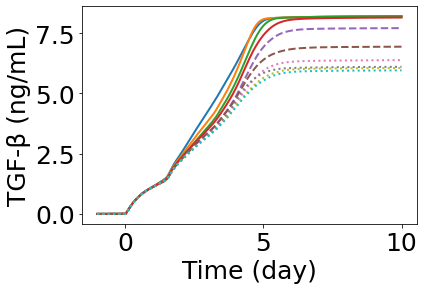

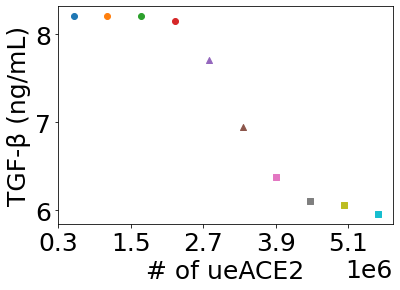

In [17]:
for i in range(number_of_cases):
    if i<4:
        plt.plot(tc1 / (24 * 60), resultC1[i, 0, :, 11], '-',  linewidth=2)
    if i>=4 and i<6:
        plt.plot(tc1 / (24 * 60), resultC1[i, 0, :, 11], '--',  linewidth=2)
    if i >= 6:
        plt.plot(tc1 / (24 * 60), resultC1[i, 0, :, 11], ':', linewidth=2)

#plt.legend(['200','400','600','800','1000','1200','1400','1600','1800','2000'], loc='upper left', prop={"size":15})
plt.xlabel('Time (day)')
plt.ylabel('TGF-β (ng/mL)')
#plt.savefig("TGF-β.png", dpi = 300, bbox_inches='tight')
plt.show()

for i in range(number_of_cases):
    if i<4:
        plt.scatter(ueACE2[i, 0, 0],(resultC1[i, 0, -1, 11] - resultC1[i, 0, N3, 11]), marker='o')
    if i>=4 and i<6:
        plt.scatter(ueACE2[i, 0, 0],(resultC1[i, 0, -1, 11] - resultC1[i, 0, N3, 11]), marker='^')
    if i >= 6:
        plt.scatter(ueACE2[i, 0, 0],(resultC1[i, 0, -1, 11] - resultC1[i, 0, N3, 11]), marker='s')
#plt.legend(['200','400','600','800','1000','1200','1400','1600','1800','2000'], ncol=2, loc='upper right', prop={"size":15})
plt.xticks(np.arange(0.3e6, 6.3e6, step=1.2e6))
plt.xlabel('# of ueACE2')
plt.ylabel('TGF-β (ng/mL)')
#plt.savefig("TGF-β.png", dpi = 300, bbox_inches='tight')
plt.show()

### Generating overlaying plot for Macrophage

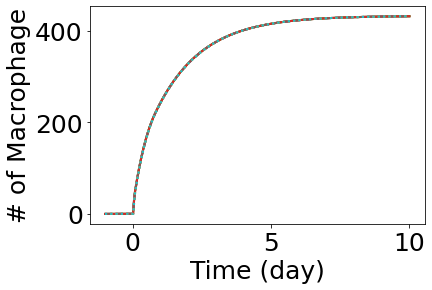

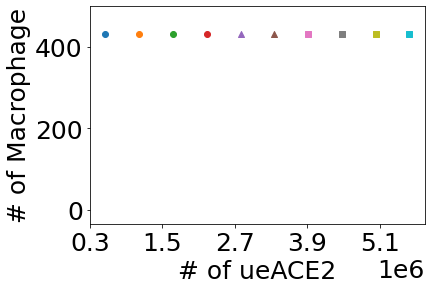

In [18]:
for i in range(number_of_cases):
    if i<4:
        plt.plot(tc1 / (24 * 60), resultC1[i, 0, :, 12], '-',  linewidth=2)
    if i>=4 and i<6:
        plt.plot(tc1 / (24 * 60), resultC1[i, 0, :, 12], '--',  linewidth=2)
    if i >= 6:
        plt.plot(tc1 / (24 * 60), resultC1[i, 0, :, 12], ':', linewidth=2)

#plt.legend(['200','400','600','800','1000','1200','1400','1600','1800','2000'], loc='upper left', prop={"size":15})
plt.xlabel('Time (day)')
plt.ylabel('# of Macrophage')
#plt.savefig("Macrophage.png", dpi = 300, bbox_inches='tight')
plt.show()

for i in range(number_of_cases):
    if i<4:
        plt.scatter(ueACE2[i, 0, 0],(resultC1[i, 0, -1, 12] - resultC1[i, 0, N3, 12]), marker='o')
    if i>=4 and i<6:
        plt.scatter(ueACE2[i, 0, 0],(resultC1[i, 0, -1, 12] - resultC1[i, 0, N3, 12]), marker='^')
    if i >= 6:
        plt.scatter(ueACE2[i, 0, 0],(resultC1[i, 0, -1, 12] - resultC1[i, 0, N3, 12]), marker='s')
#plt.legend(['200','400','600','800','1000','1200','1400','1600','1800','2000'], ncol=2, loc='lower right', prop={"size":15})
plt.ylim([-500*0.07,500])
plt.xticks(np.arange(0.3e6, 6.3e6, step=1.2e6))
plt.xlabel('# of ueACE2')
plt.ylabel('# of Macrophage')
#plt.savefig("Macrophage.png", dpi = 300, bbox_inches='tight')
plt.show()

### Generating overlaying plot for Fibroblast

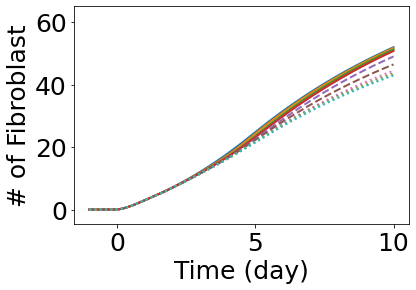

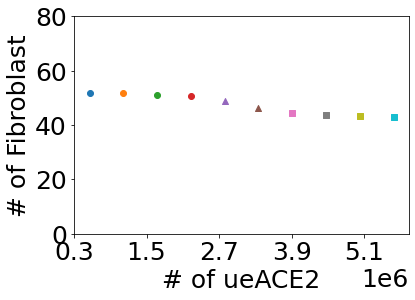

In [19]:
for i in range(number_of_cases):
    if i<4:
        plt.plot(tc1 / (24 * 60), resultC1[i, 0, :, 13], '-',  linewidth=2)
    if i>=4 and i<6:
        plt.plot(tc1 / (24 * 60), resultC1[i, 0, :, 13], '--',  linewidth=2)
    if i >= 6:
        plt.plot(tc1 / (24 * 60), resultC1[i, 0, :, 13], ':', linewidth=2)

plt.ylim([-65*0.07,65])
#plt.legend(['200','400','600','800','1000','1200','1400','1600','1800','2000'], loc='upper left', prop={"size":15})
plt.xlabel('Time (day)')
plt.ylabel('# of Fibroblast')
#plt.savefig("Fibroblast.png", dpi = 300, bbox_inches='tight')
plt.show()

for i in range(number_of_cases):
    if i<4:
        plt.scatter(ueACE2[i, 0, 0],(resultC1[i, 0, -1, 13] - resultC1[i, 0, N3, 13]), marker='o')
    if i>=4 and i<6:
        plt.scatter(ueACE2[i, 0, 0],(resultC1[i, 0, -1, 13] - resultC1[i, 0, N3, 13]), marker='^')
    if i >= 6:
        plt.scatter(ueACE2[i, 0, 0],(resultC1[i, 0, -1, 13] - resultC1[i, 0, N3, 13]), marker='s')
#plt.legend(['200','400','600','800','1000','1200','1400','1600','1800','2000'], ncol=2, loc='lower right', prop={"size":15})
plt.ylim([0,80])
plt.xticks(np.arange(0.3e6, 6.3e6, step=1.2e6))
plt.xlabel('# of ueACE2')
plt.ylabel('# of Fibroblast')
#plt.savefig("Fibroblast.png", dpi = 300, bbox_inches='tight')
plt.show()

### Generating overlaying plot for Collagen

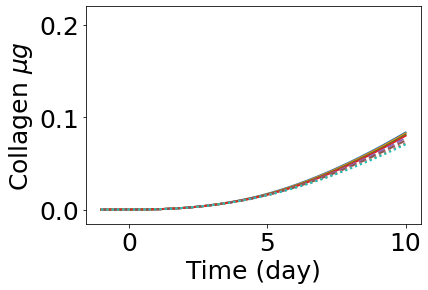

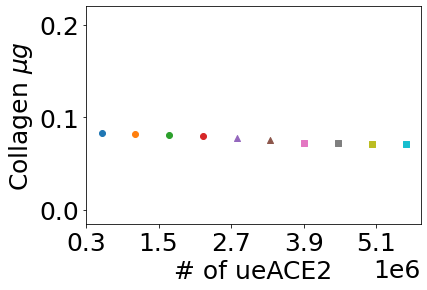

In [20]:
for i in range(number_of_cases):
    if i<4:
        plt.plot(tc1 / (24 * 60), resultC1[i, 0, :, 14], '-',  linewidth=2)
    if i>=4 and i<6:
        plt.plot(tc1 / (24 * 60), resultC1[i, 0, :, 14], '--',  linewidth=2)
    if i >= 6:
        plt.plot(tc1 / (24 * 60), resultC1[i, 0, :, 14], ':', linewidth=2)

plt.ylim([-0.22*0.07,0.22])
#plt.legend(['200','400','600','800','1000','1200','1400','1600','1800','2000'], loc='upper left', prop={"size":15})
plt.xlabel('Time (day)')
plt.ylabel('Collagen $μg$')
#plt.savefig("Collagen.png", dpi = 300, bbox_inches='tight')
plt.show()

for i in range(number_of_cases):
    if i<4:
        plt.scatter(ueACE2[i, 0, 0],(resultC1[i, 0, -1, 14] - resultC1[i, 0, N3, 14]), marker='o')
    if i>=4 and i<6:
        plt.scatter(ueACE2[i, 0, 0],(resultC1[i, 0, -1, 14] - resultC1[i, 0, N3, 14]), marker='^')
    if i >= 6:
        plt.scatter(ueACE2[i, 0, 0],(resultC1[i, 0, -1, 14] - resultC1[i, 0, N3, 14]), marker='s')
#plt.legend(['200','400','600','800','1000','1200','1400','1600','1800','2000'], ncol=2, loc='lower right', prop={"size":15})
plt.ylim([-0.22*0.07,0.22])
plt.xticks(np.arange(0.3e6, 6.3e6, step=1.2e6))
plt.xlabel('# of ueACE2')
plt.ylabel('Collagen $μg$')
#plt.savefig("Collagen.png", dpi = 300, bbox_inches='tight')
plt.show()